# Simulating exoplanet search phase

Following the [First Examples LIFEsim tutorial](https://lifesim.readthedocs.io/en/latest/example.html) and [GitHub documentation](https://github.com/fdannert/LIFEsim/blob/master/lifesim_demo.py) we explore one of the two main functionalities of LIFEsim: simulating the LIFE search phase on a catalog of a simulated exoplanets population. By taking an artificial exoplanet catalog input from P-Pop, the SNR ratio for each planet is calculated and the observation time available in the search phase is distributed to observe and detect an optimal number of exoplanets.

## Simulating spectrum of an exoplanet using the GUI

Running LIFEsim's `Gui()`, we simulate an absolute exoplanet spectrum using _spec.txt_ from [the LIFEsim GitHub](https://github.com/fdannert/LIFEsim/blob/master/docs/_static/example_spectrum.txt).

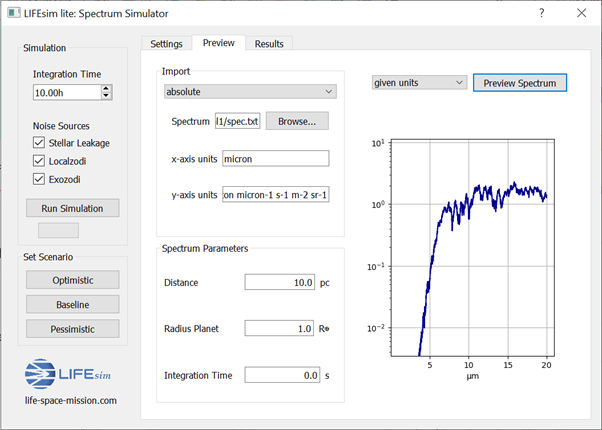

An additive spectrum without any spectral data input generates a blackbody curve.

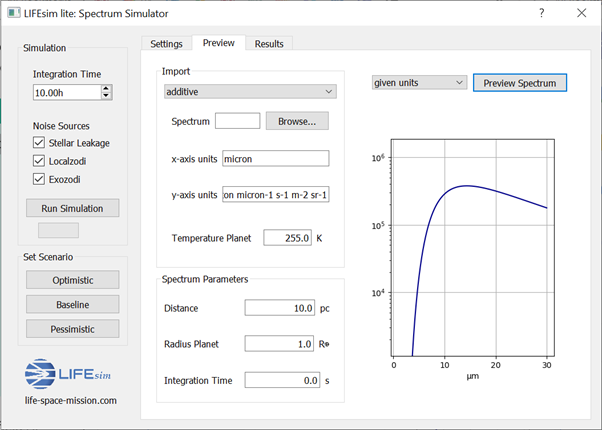

Running the simulation with the same parameters in different (optimistic/baseline/pessimistic) scenarios gives the results as shown below.

Optimistic | Baseline | Pessimistic
-|-|-
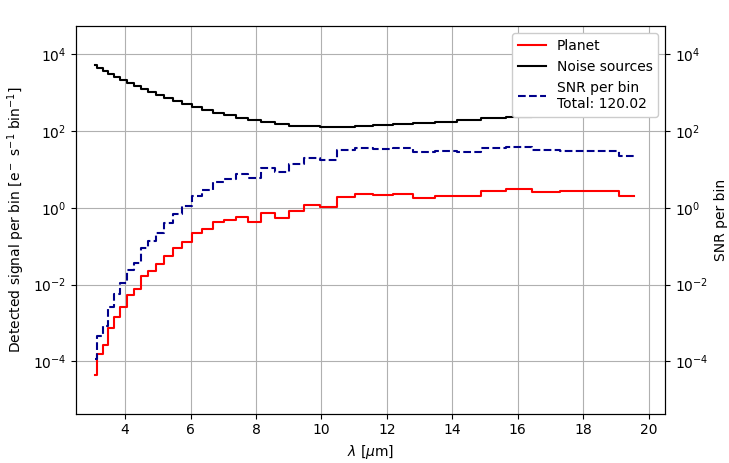 | 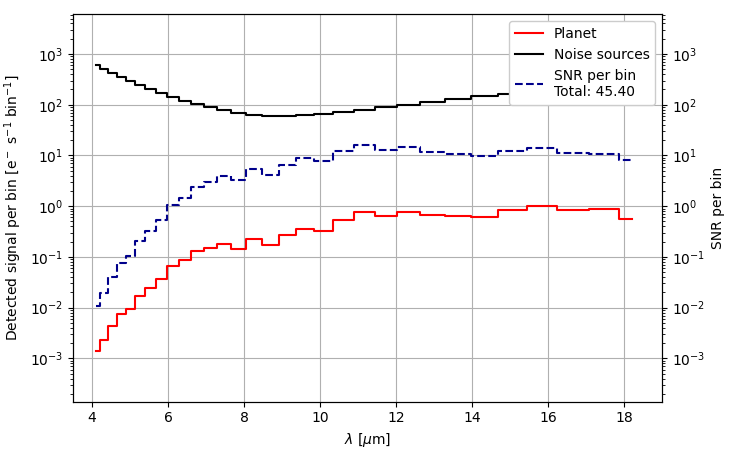 | 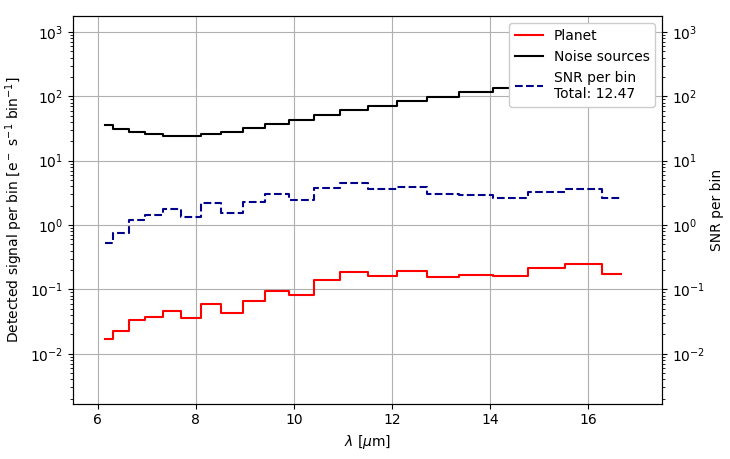


It is clear from the plots that less exoplanets are detected in more pessimistic scenarios and more exoplanets are detected in more optimistic scenarios.

## Simulating a catalogue of exoplanets using LIFEsim

### Setting up

In [3]:
#import the necessary packages
import lifesim
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
#create an bus to save all data and parameters
bus=lifesim.Bus()

In [5]:
#set the parameters to the baseline case
bus.data.options.set_scenario('baseline')

In [6]:
#change collector aperture diameter
bus.data.options.set_manual(diameter=4.)

### Downloading and loading the catalogue

Using an example synthetic planet population based on statistics from the Kepler mission from the P-Pop github page https://github.com/kammerje/P-pop.

In [7]:
#downloading the catalog
data = requests.get('https://raw.githubusercontent.com/kammerje/P-pop/main/TestPlanetPopulation.txt')

with open('ppop_catalog.txt', 'wb') as file:
    file.write(data.content)
#defining a path for ppop_catalog.txt was giving an error, so we save to the default folder.

In [8]:
#loading the catalog
bus.data.catalog_from_ppop(input_path='ppop_catalog.txt')

Processed line 45884 of 45884


**Note:** The given P-Pop catalog populates known stars in the solar neighborhood of up to 20 pc with artificial planets based on the Kepler statistics. This population is done in a Monte Carlo approach, simulating 500 different universes, which is important to keep in mind when the results are interpreted.

In [9]:
#remove all A-type stars
bus.data.catalog_remove_distance(stype='A', mode='larger', dist=0.)

#remove all M-type stars at a distance > 10 pc from Earth
bus.data.catalog_remove_distance(stype='M', mode='larger', dist=10.)

### Creating the Instrument

In [10]:
#create an instance of the LIFEsim instrument module
instrument = lifesim.Instrument(name='inst')

In [11]:
#connect instrument module to the bus
bus.add_module(instrument)

#note: running more than once will give an error 'already in use on the bus'

In [12]:
#creating all modules needed for the instrument module to run

#transmission module responsible for simulating transmission maps of a 4-arm nulling interferometer
transm = lifesim.TransmissionMap(name='transm')
#add transmission module to the bus
bus.add_module(transm)

In [13]:
#create modules for the simulation of the astrophysical noise sources
# + add them to bus
exozodi = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exozodi)
localzodi = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(localzodi)
star_leak = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star_leak)

In [14]:
#tell the instrument which modules to connect to
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))

bus.connect(('star', 'transm'))

In [15]:
#to disconnect individual noise sources
#bus.disconnect(('inst', 'exo'))

### Creating the Optimizer

Responsible for distributing the available observing time onto the individual stars.

In [16]:
opt = lifesim.Optimizer(name='opt')
bus.add_module(opt)
ahgs = lifesim.AhgsModule(name='ahgs')
bus.add_module(ahgs)

bus.connect(('transm', 'opt'))
bus.connect(('inst', 'opt'))
bus.connect(('opt', 'ahgs'))

### Running the simulation

In [17]:
#calculate SNR for every planet in the catalog
instrument.get_snr()

100%|████████████████████████████████████████████████████████████████████████████████| 535/535 [03:35<00:00,  2.48it/s]


**Note:** This function will assign every planet the SNR after 1 hr of observation. Since the simulation is entirely contained in the radom noise case, the SNR scales with $\sqrt{t_\mathrm{integration}}$. So for any integration time, $t_\mathrm{integration}$, the SNR can be calculated by knowing the SNR of a specific integration time.

In [18]:
#knowing the SNR for each planet
#distribute the integration time optimally
opt.ahgs()

Number of planets detected by stellar type:
A: 0.0  F: 1.7  G: 5.8  K: 35.4  M: 38.3  -  (2.0 / 2.0) yrs observed


**Note**: In the baseline code, the observation time is distributed such that the number of planets in the habitable zone around their respective host stars is optimized.

In [19]:
#change optimization to respect all planets
bus.data.options.optimization['habitable'] = True

### Saving the Results

In [20]:
#bus.data.export_catalog(output_path='file.hdf5')
# set options manually
#bus.data.options.set_manual(output_path='C:\\Users\\franc\\Desktop\\Astrobiology\\astrobiology\\')
#bus.data.options.set_manual(output_filename='run_name')
#bus.save()

In [21]:
#save the results
df = bus.data.catalog
df.to_csv('C:\\Users\\franc\\Desktop\\Astrobiology\\astrobiology\\data')

### Reading the Results

In [92]:
df = pd.read_csv('C:\\Users\\franc\\Desktop\\Astrobiology\\astrobiology\\data', index_col=0)

In [93]:
#import the previously saved catalog
#bus_read = lifesim.Bus()
#bus_read.build_from_config('C:\\Users\\franc\\Desktop\\Astrobiology\\astrobiology\\run_name.yaml')
#bus_read.data.import_catalog(input_path='C:\\Users\\franc\\Desktop\\Astrobiology\\astrobiology\\run_name_catalog.hdf5')

### Interpreting Results

All results are saved in the catalog located at `bus.data.catalog`. This `pandas` dataframe contains rows = individual artificial exoplanets. For columns meanings refer to `LIFEsim/lifesim/core/data.py`. The most important columns are:

- `nuniverse`: index of the universe the planet is located in
- `nstar`: unique index of star
- `habitable`: `true` if the planet resides in the habitable zone of its host star
- `snr_1h`: the SNR that the planet would have after 1hr of integration time
- `detected`: `true` if the planet is observed long enough to have an SNR larger than `bus.data.option.optimization['snr_target']`. In this case, the planet is counted towards the planets detected in the search phase
- `int_time`: amount of integration time spent on the system, in seconds

In [94]:
print(df)

       radius_p      p_orb   mass_p  ecc_p    inc_p  large_omega_p  \
0       2.55899    1.21237  6.46922    0.0  0.36825        0.83082   
1       1.62557   95.32925  2.94136    0.0  0.36825        4.71701   
2       0.64641  413.44526  0.18259    0.0  0.36825        3.59078   
3       1.45874   51.20469  5.36760    0.0  2.01016        2.62388   
4       2.03712   98.57858  4.45356    0.0  2.01016        1.71757   
...         ...        ...      ...    ...      ...            ...   
13999   0.82089   48.64809  3.00300    0.0  1.36699        3.29171   
14000   0.76631    3.78368  0.47407    0.0  2.15206        1.81751   
14001   1.29841   30.83798  1.36537    0.0  2.15206        5.07573   
14002   1.31487  184.70674  1.57873    0.0  2.15206        4.52980   
14003   0.58477  435.93984  0.21112    0.0  2.15206        5.56653   

       small_omega_p  theta_p  albedo_bond  albedo_geom_vis  ...     hz_in  \
0            4.28658  0.46104      0.07323          0.11134  ...  0.745910   
1  

The stellar types are: A, F, G, K, M.


In [95]:
#use selection masks for interpretation of the catalog
#retreive the number of detected exoplanets in the habitable zone around M-type stars
mask_mtype = df['stype'] == 'M'
mask = np.logical_and.reduce((df['detected'], df['habitable']==True, mask_mtype))
results_number = mask.sum()/500 #to factor out the 500 simulated universes

mask2 = np.logical_and.reduce((df['detected'], df['habitable']==False, mask_mtype))
results_number2 = mask2.sum()/500 #to factor out the 500 simulated universes

In [96]:
print('The number of detected exoplanets in the habitable zone around M-type stars is '+ str(results_number)+'.')
print('The number of detected exoplanets outside the habitable zone around M-type stars is '+ str(results_number2)+'.')

The number of detected exoplanets in the habitable zone around M-type stars is 0.766.
The number of detected exoplanets outside the habitable zone around M-type stars is 2.654.


In [97]:
types = ['A', 'F', 'G', 'K', 'M']
exo_found = np.zeros((len(types), 2))
print(exo_found)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [98]:
i=0
for type in types:
    print('Looking for exoplanets of type: '+type)
    mask_mtype = df['stype'] == type

    #habitable exoplanets
    mask = np.logical_and.reduce((df['detected'], df['habitable']==True, mask_mtype))
    exo_found[i,0] = mask.sum()/500 #to factor out the 500 simulated universes - What does this mean exactly??
    print('Habitable: ', exo_found[i,0])

    #not habitable
    mask2 = np.logical_and.reduce((df['detected'], df['habitable']==False, mask_mtype))
    exo_found[i,1] = mask2.sum()/500 #to factor out the 500 simulated universes - What does this mean exactly??
    print('Not habitable: ', exo_found[i,1])

    #total number of exoplanets detected of type
    mask_tot = df[mask_mtype]['detected']
    tot_number = mask_tot.sum()/500 #to factor out the 500 simulated universes - What does this mean exactly
    print('Total: ', tot_number)
    print()
    i = i+1

Looking for exoplanets of type: A
Habitable:  0.0
Not habitable:  0.0
Total:  0.0

Looking for exoplanets of type: F
Habitable:  0.034
Not habitable:  0.358
Total:  0.392

Looking for exoplanets of type: G
Habitable:  0.116
Not habitable:  0.842
Total:  0.958

Looking for exoplanets of type: K
Habitable:  0.708
Not habitable:  4.506
Total:  5.214

Looking for exoplanets of type: M
Habitable:  0.766
Not habitable:  2.654
Total:  3.42



Note that there are no exoplanets detected of type 'A' because we have removed them.

In [99]:
print(exo_found)

[[0.    0.   ]
 [0.034 0.358]
 [0.116 0.842]
 [0.708 4.506]
 [0.766 2.654]]


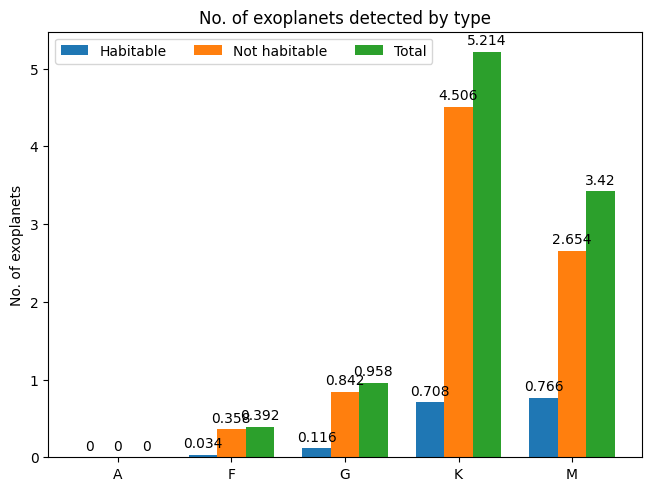

In [100]:
exo_data = {
    'Habitable': exo_found[:,0],
    'Not habitable': exo_found[:,1],
    'Total': exo_found[:,0]+exo_found[:,1],
}

x = np.arange(len(types))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in exo_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No. of exoplanets')
ax.set_title('No. of exoplanets detected by type')
ax.set_xticks(x + width, types)
ax.legend(loc='upper left', ncols=3)
#ax.set_ylim(0, 1)

plt.show()

In [101]:
x=np.arange(0, len(types), 1)
print(x)

[0 1 2 3 4]


### Computing the Correlation

In [102]:
#correlation coefficient between radius of planet and orbital
np.corrcoef(df['radius_p'], df['p_orb'])

array([[1.       , 0.0601538],
       [0.0601538, 1.       ]])

In [103]:
#try with different variables?
np.corrcoef(df['mass_p'], df['habitable'])
#NO correlation can be found with 'string' types - which are these?
#True/False types can be used in correlation matrix

array([[ 1.        , -0.01534787],
       [-0.01534787,  1.        ]])

In [104]:
#convert the data type which is notfloat
notfloat=df.columns[(df.dtypes.values != np.dtype('float64'))]
for i in range(len(notfloat)):
    df[notfloat[i]] = df[notfloat[i]].astype('category').cat.codes
    
print(notfloat)

Index(['nuniverse', 'nstar', 'stype', 'id', 'habitable', 'detected'], dtype='object')


The above listed categories are those which were previously not of type 'float', and have now been converted into 'float' type.

In [105]:
#use standard pearson correlation method
df.corr(method='pearson', min_periods=1, numeric_only=False)

,radius_p,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,...,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew
radius_p,1.000000,0.060154,0.233736,NaN,-0.011677,0.004711,-0.008127,-0.002783,-0.004725,-0.006150,...,0.015707,0.016638,0.016354,-0.218448,0.463719,-0.020561,0.170159,0.363647,-0.035093,-0.028597
p_orb,0.060154,1.000000,0.022246,NaN,0.001964,0.016534,0.003619,-0.006077,-0.005634,0.003135,...,0.011497,0.011754,0.011677,0.147501,-0.118478,-0.011824,-0.278971,-0.110091,0.005584,0.005354
mass_p,0.233736,0.022246,1.000000,NaN,0.006376,0.006804,0.006553,-0.000637,-0.008731,-0.009113,...,-0.008800,-0.008932,-0.008892,-0.015348,0.090460,0.007142,0.002669,0.081141,-0.009442,-0.009441
ecc_p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inc_p,-0.011677,0.001964,0.006376,NaN,1.000000,-0.009826,0.005399,-0.002307,-0.000720,-0.011130,...,-0.007007,-0.007649,-0.007452,0.000448,-0.018186,0.006085,0.001105,-0.024002,0.000331,0.008450
large_omega_p,0.004711,0.016534,0.006804,NaN,-0.009826,1.000000,-0.008723,0.003562,-0.007828,0.005264,...,-0.006508,-0.006412,-0.006443,-0.004013,0.003151,0.011699,-0.004182,0.012245,0.004396,0.002517
small_omega_p,-0.008127,0.003619,0.006553,NaN,0.005399,-0.008723,1.000000,-0.013251,0.008850,-0.002356,...,0.003797,0.003507,0.003596,0.007174,-0.005410,0.003229,-0.006869,-0.003165,0.008034,0.000877
theta_p,-0.002783,-0.006077,-0.000637,NaN,-0.002307,0.003562,-0.013251,1.000000,0.015044,0.012196,...,0.005326,0.005290,0.005302,0.012007,0.005540,-0.007962,0.000958,-0.009440,-0.021767,-0.003854
albedo_bond,-0.004725,-0.005634,-0.008731,NaN,-0.000720,-0.007828,0.008850,0.015044,1.000000,0.002917,...,0.006070,0.005824,0.005900,-0.018924,-0.089658,-0.007836,-0.124514,-0.068188,-0.003552,-0.009921
albedo_geom_vis,-0.006150,0.003135,-0.009113,NaN,-0.011130,0.005264,-0.002356,0.012196,0.002917,1.000000,...,0.011550,0.011723,0.011672,0.001733,-0.011998,-0.004004,-0.000289,0.005930,0.007891,0.002369


In [106]:
list(df.columns.values)

['radius_p',
 'p_orb',
 'mass_p',
 'ecc_p',
 'inc_p',
 'large_omega_p',
 'small_omega_p',
 'theta_p',
 'albedo_bond',
 'albedo_geom_vis',
 'albedo_geom_mir',
 'z',
 'semimajor_p',
 'sep_p',
 'angsep',
 'maxangsep',
 'flux_p',
 'fp',
 'temp_p',
 'radius_s',
 'mass_s',
 'temp_s',
 'distance_s',
 'ra',
 'dec',
 'nuniverse',
 'nstar',
 'stype',
 'id',
 'name_s',
 'lon',
 'lat',
 's_in',
 's_out',
 'l_sun',
 'hz_in',
 'hz_out',
 'hz_center',
 'habitable',
 'snr_1h',
 'baseline',
 'detected',
 'snr_current',
 'int_time',
 't_slew']

In [107]:
#remove columns which do not matter in correlation e.g. identifiers
cut_df = df.drop('id', axis=1)
cut_df = cut_df.drop('baseline', axis=1)
cut_df = cut_df.drop('name_s', axis=1)
cut_df = cut_df.drop('ra', axis=1)
cut_df = cut_df.drop('dec', axis=1)
cut_df = cut_df.drop('lon', axis=1)
cut_df = cut_df.drop('lat', axis=1)
cut_df = cut_df.drop('s_in', axis=1)
cut_df = cut_df.drop('s_out', axis=1)

#drop zero columns
cut_df = cut_df.drop('ecc_p', axis=1)

list(cut_df.columns.values)

['radius_p',
 'p_orb',
 'mass_p',
 'inc_p',
 'large_omega_p',
 'small_omega_p',
 'theta_p',
 'albedo_bond',
 'albedo_geom_vis',
 'albedo_geom_mir',
 'z',
 'semimajor_p',
 'sep_p',
 'angsep',
 'maxangsep',
 'flux_p',
 'fp',
 'temp_p',
 'radius_s',
 'mass_s',
 'temp_s',
 'distance_s',
 'nuniverse',
 'nstar',
 'stype',
 'l_sun',
 'hz_in',
 'hz_out',
 'hz_center',
 'habitable',
 'snr_1h',
 'detected',
 'snr_current',
 'int_time',
 't_slew']

In [110]:
correlation = cut_df.corr(method='pearson', min_periods=1, numeric_only=False)

Text(0.5, 1.0, 'Correlation Matrix')

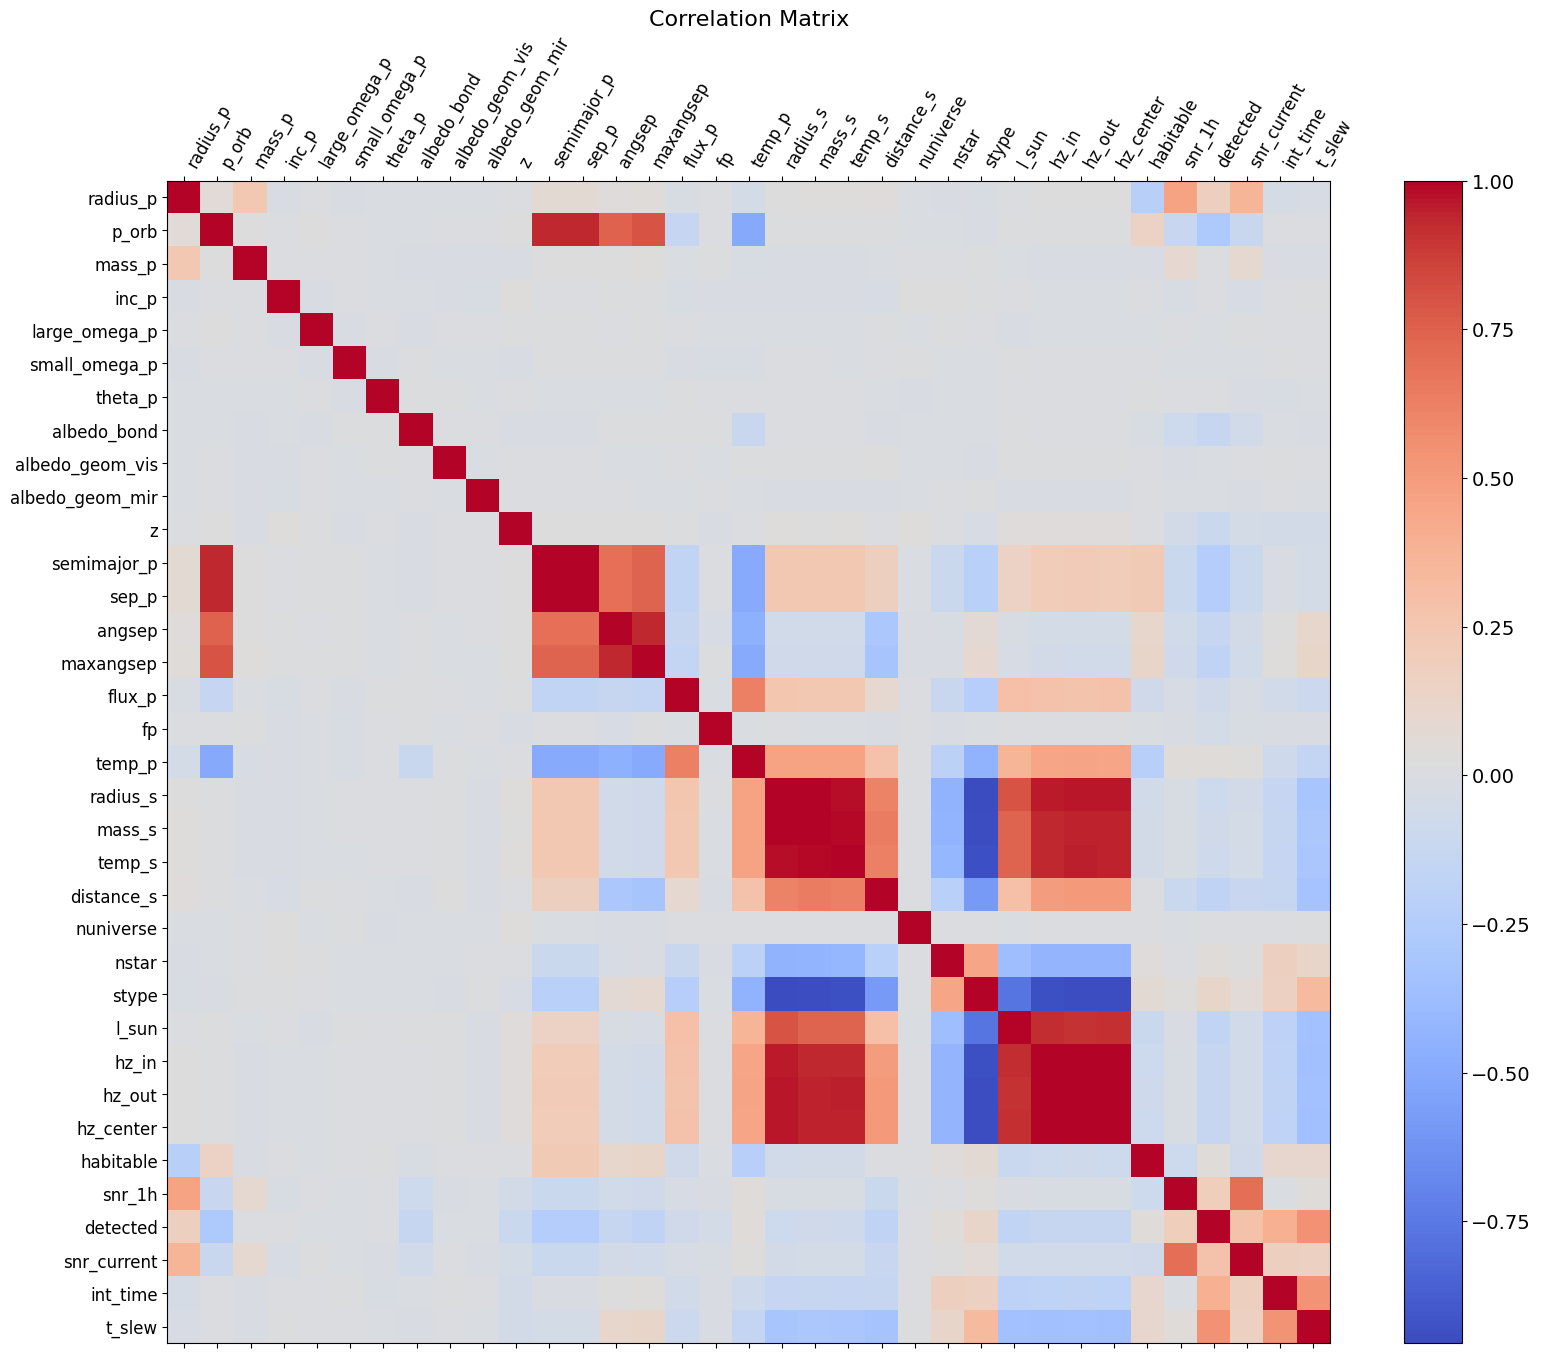

In [125]:
#plotting the correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(cut_df.corr(), fignum=f.number, cmap='coolwarm')
plt.xticks(range(cut_df.select_dtypes(['number']).shape[1]), cut_df.select_dtypes(['number']).columns, fontsize=12, rotation=60, horizontalalignment='left')
plt.yticks(range(cut_df.select_dtypes(['number']).shape[1]), cut_df.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

From the above plot, we can see that some variables are highly correlated and others highly anti-correlated, while others have low/no correlation.